# Compare mutation effects on ACE2 binding vs sera escape at key sites
This notebook compares how different mutations affect ACE2 binding versus escape at key sites.

In [1]:
# this cell is tagged as parameters for `papermill` parameterization
dms_csv = None
logoplot_subdir = None

In [2]:
# Parameters
dms_csv = "results/summaries/summary.csv"
logoplot_subdir = "results/binding_vs_escape/logoplots"


import os
os.chdir("../")

In [20]:
import os

import altair as alt

import dmslogo

import matplotlib
import matplotlib.pyplot as plt

import numpy

import palettable

import pandas as pd

os.makedirs(logoplot_subdir, exist_ok=True)

## Read input data

In [4]:
min_cell_entry = -1.5  # only keep mutations with cell entry at least this good
min_mutations_at_site = 7  # only keep sites with at least this many mutations

dms_df = (
    pd.read_csv(dms_csv)
    .rename(columns={"human sera escape": "sera escape", "spike mediated entry": "cell entry"})
    .dropna(subset=["sera escape", "cell entry", "ACE2 binding"])
    .query("`cell entry` >= @min_cell_entry")
    .query("mutant not in ['*', '-']")  # exclude stop and gap
    .assign(
        mutation=lambda x: x["wildtype"] + x["site"].astype(str) + x["mutant"],
        n_mutations_at_site=lambda x: x.groupby("site")["mutant"].transform("count"),
    )
    .query("n_mutations_at_site >= @min_mutations_at_site")
    .reset_index(drop=True)
)

dms_df

,site,wildtype,mutant,sera escape,cell entry,ACE2 binding,sequential_site,region,mutation,n_mutations_at_site
0,3,V,A,0.024020,-0.041540,-0.049770,3,other,V3A,7
1,3,V,F,0.112700,-0.105700,0.113900,3,other,V3F,7
2,3,V,G,-0.122400,-0.002075,-0.189000,3,other,V3G,7
3,3,V,I,-0.113900,-0.120400,-0.138400,3,other,V3I,7
4,3,V,L,-0.025990,0.033060,-0.108000,3,other,V3L,7
...,...,...,...,...,...,...,...,...,...,...
3255,1252,S,F,-0.006158,0.100700,-0.012280,1248,other,S1252F,7
3256,1252,S,P,-0.004025,0.077520,0.053890,1248,other,S1252P,7
3257,1252,S,T,0.001764,0.003655,-0.114200,1248,other,S1252T,7
3258,1252,S,Y,-0.006188,0.058880,0.000546,1248,other,S1252Y,7


## Calculate correlation between ACE2 binding and escape for each site

In [5]:
# compute correlations
correlation_df = (
    dms_df
    .groupby("site")
    [["sera escape", "ACE2 binding"]]
    .corr()
    .reset_index()
    .query("level_1 == 'sera escape'")
    .rename(columns={"ACE2 binding": "correlation"})
    [["site", "correlation"]]
    .dropna(subset="correlation")
    .reset_index(drop=True)
)

# add correlations to DMS data frame
dms_df = dms_df.merge(correlation_df, validate="many_to_one")

dms_df

,site,wildtype,mutant,sera escape,cell entry,ACE2 binding,sequential_site,region,mutation,n_mutations_at_site,correlation
0,3,V,A,0.024020,-0.041540,-0.049770,3,other,V3A,7,0.884780
1,3,V,F,0.112700,-0.105700,0.113900,3,other,V3F,7,0.884780
2,3,V,G,-0.122400,-0.002075,-0.189000,3,other,V3G,7,0.884780
3,3,V,I,-0.113900,-0.120400,-0.138400,3,other,V3I,7,0.884780
4,3,V,L,-0.025990,0.033060,-0.108000,3,other,V3L,7,0.884780
...,...,...,...,...,...,...,...,...,...,...,...
3255,1252,S,F,-0.006158,0.100700,-0.012280,1248,other,S1252F,7,-0.288667
3256,1252,S,P,-0.004025,0.077520,0.053890,1248,other,S1252P,7,-0.288667
3257,1252,S,T,0.001764,0.003655,-0.114200,1248,other,S1252T,7,-0.288667
3258,1252,S,Y,-0.006188,0.058880,0.000546,1248,other,S1252Y,7,-0.288667


## Plot sites with high inverse correlation between ACE2 binding and escape
Plot sites with high inverse correlation of binding and escape; note the slider at the bottom can control which sites are shown:

In [6]:
# first make base chart

facet_size = 100

cell_entry_slider = alt.param(
    value=min_cell_entry,
    bind=alt.binding_range(
        name="minimum cell entry",
        min=dms_df["cell entry"].min(),
        max=0,
    ),
)

binding_escape_corr_base = (
    alt.Chart(dms_df)
    .add_params(cell_entry_slider)
    .transform_filter(alt.datum["cell entry"] >= cell_entry_slider)
)

binding_escape_corr_chart = (
    (
        (
            binding_escape_corr_base
            .encode(
                x=alt.X("ACE2 binding", scale=alt.Scale(nice=False, padding=6)),
                y=alt.Y("sera escape", scale=alt.Scale(nice=False, padding=6)),
                tooltip=[
                    "site",
                    "mutation",
                    alt.Tooltip("ACE2 binding", format=".2f"),
                    alt.Tooltip("sera escape", format=".2f"),
                    alt.Tooltip("cell entry", format=".2f"),
                ],
            )           
            .mark_circle(color="black", opacity=0.3, size=60)
        )
        + (
            binding_escape_corr_base
            .transform_regression("ACE2 binding", "sera escape", params=True)
            .transform_calculate(
                r=alt.expr.if_(
                    alt.datum["coef"][1] > 0,
                    alt.expr.sqrt(alt.datum["rSquared"]),
                    -alt.expr.sqrt(alt.datum["rSquared"]),
                ),
                r_text="r = " + alt.expr.format(alt.datum["r"], ".2f"),
            )
            .encode(
                text="r_text:N",
                x=alt.value(3),
                y=alt.value(facet_size - 6),
            )
            .mark_text(size=12, align="left", color="blue")
        )
    )
    .properties(width=facet_size, height=facet_size)
    .facet(
        facet=alt.Facet(
            "site",
            title=None,
            header=alt.Header(
                labelFontSize=14,
                labelFontStyle="italic",
                labelPadding=0,
                labelExpr="'site ' + datum.label",
            )
        ),
        spacing=8,
        columns=8,
    )
    .configure_axis(grid=False)
)

# now make chart filtered for strongly negative correlations
max_corr_slider = alt.param(
    value=-0.82,
    bind=alt.binding_range(
        name="only show sites with correlation r less than this",
        min=-1,
        max=1,
        step=0.01,
    ),
)

binding_escape_neg_corr_chart = (
    binding_escape_corr_chart
    .properties(
        title=alt.TitleParams(
            "Correlation of ACE2 binding and escape filtered by extent of negative correlation",
            anchor="middle",
            fontSize=16,
            dy=-5,
        ),
        autosize=alt.AutoSizeParams(resize=True),
    )
    .add_params(max_corr_slider)
    .transform_filter(alt.datum["correlation"] <= max_corr_slider)
)

binding_escape_neg_corr_chart

alt.FacetChart(...)

## We now plot the same correlation for sites of strong escape
We manually specify some sites of strong escape:

In [7]:
escape_sites = [357, 420, 440, 444, 452, 456, 473]

binding_escape_high_escape_corr_chart = (
    binding_escape_corr_chart
    .properties(
        title=alt.TitleParams(
            "Correlation of ACE2 binding and escape for sites of strong escape",
            anchor="middle",
            fontSize=16,
            dy=-5,
        ),
        autosize=alt.AutoSizeParams(resize=True),
    )
    .transform_filter(alt.FieldOneOfPredicate("site", escape_sites))
)

binding_escape_high_escape_corr_chart

alt.FacetChart(...)

## Plot sites of top escape in and not in receptor-binding motif (RBM) of RBD
We plot both binding-escape correlation plots and logo plots for the sites with the most escaping mutations in both the RBD and non-RBD:

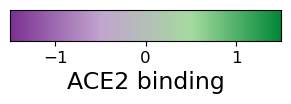

Saving to results/binding_vs_escape/logoplots/ace2_scalebar_horizontal.svg


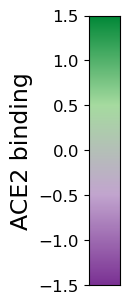

Saving to results/binding_vs_escape/logoplots/ace2_scalebar_vertical.svg


Analyzing top sites for is_rbm=True


,wildtype,mutant,sera escape,cell entry,ACE2 binding,sequential_site,region,mutation,n_mutations_at_site,correlation
site,,,,,,,,,,
473,Y,D,0.8930,-0.15880,-1.7180,469,RBD,Y473D,19,-0.809442
475,A,D,0.7186,0.02661,-1.1540,471,RBD,A475D,14,0.035528
456,F,S,0.7081,-0.27810,-0.6061,452,RBD,F456S,14,0.149154
504,G,F,0.5447,0.10030,-0.1576,500,RBD,G504F,13,-0.451384
455,L,P,0.5365,-0.03330,-1.0330,451,RBD,L455P,16,-0.657878
440,K,W,0.4584,0.03784,-0.4307,436,RBD,K440W,14,-0.281435
476,G,D,0.3936,-0.10940,-0.8305,472,RBD,G476D,7,-0.219767


alt.FacetChart(...)

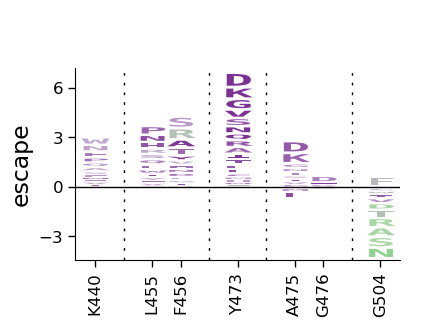



Analyzing top sites for is_rbm=False


,wildtype,mutant,sera escape,cell entry,ACE2 binding,sequential_site,region,mutation,n_mutations_at_site,correlation
site,,,,,,,,,,
421,Y,R,0.8643,-0.545900,0.02215,417,RBD,Y421R,15,0.193231
357,R,H,0.8229,-0.078240,-0.78280,353,RBD,R357H,18,-0.680207
375,F,L,0.7919,-0.141600,-0.80370,371,RBD,F375L,18,-0.958125
376,A,D,0.7630,0.008447,-0.64790,372,RBD,A376D,20,-0.911399
200,Y,I,0.6693,-0.010090,-0.63070,196,NTD,Y200I,7,-0.811003
132,E,V,0.6685,-0.094380,-0.58930,129,NTD,E132V,9,-0.891411
572,T,K,0.6554,0.022590,-1.07000,568,other,T572K,17,-0.817537


alt.FacetChart(...)

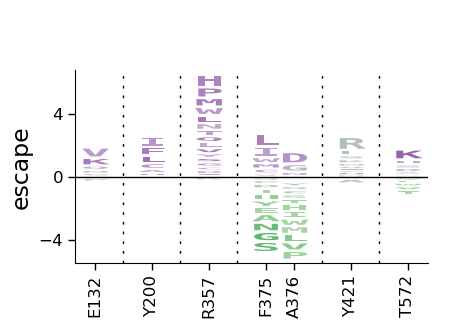

In [28]:
top_n = 7

# define RBM sites as in https://www.sciencedirect.com/science/article/pii/S1931312820306247
# which uses definition from https://www.science.org/doi/full/10.1126/science.1116480
rbm_sites = list(range(437, 508))

# for coloring by ACE2
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=-1.5,
    maxvalue=1.5,
    cmap=palettable.colorbrewer.diverging.PRGn_4.mpl_colormap,
    #cmap=palettable.colorbrewer.diverging.PuOr_4.mpl_colormap,
    #cmap=palettable.lightbartlein.diverging.BlueOrange8_2.mpl_colormap,
)
for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    display(fig)
    svg = os.path.join(logoplot_subdir, f"ace2_scalebar_{orientation}.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

for is_rbm in [True, False]:

    print(f"\n\nAnalyzing top sites for {is_rbm=}")

    # get dataframe with RBM or non-RBM sites
    df = dms_df[dms_df["site"].isin(rbm_sites) == is_rbm]

    # get sites of top escape mutations
    top_escape_sites = (
        df
        .sort_values("sera escape", ascending=False)
        .groupby("site", sort=False)
        .first()
        .head(top_n)
    )
    sites = top_escape_sites.index.tolist()
    display(top_escape_sites)

    # plot correlation for these top sites
    corr_chart = (
        binding_escape_corr_chart
        .properties(
            title=alt.TitleParams(
                f"Correlation of ACE2 binding and escape for {'RBM' if is_rbd else'non-RBM'} sites where mutations cause strong escape",
                anchor="middle",
                fontSize=16,
                dy=-5,
            ),
            autosize=alt.AutoSizeParams(resize=True),
        )
        .transform_filter(alt.FieldOneOfPredicate("site", sites))
    )
    display(corr_chart)

    # make logo plot
    fig, _ = dmslogo.draw_logo(
        data=df[df["site"].isin(sites)].rename(columns={"sera escape": "escape"}).assign(
            wildtype_site=lambda x: x["wildtype"] + x["site"].astype(str),
            color=lambda x: (
                x["ACE2 binding"]
                .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
                .map(ace2_colormap.val_to_color)
            ),
        ),
        x_col="sequential_site",
        letter_col="mutant",
        color_col="color",
        xtick_col="wildtype_site",
        letter_height_col="escape",
        xlabel="",
    )
    display(fig)
    plt.close(fig)

In [11]:
df["sera escape"]

1352    0.142300
1353   -0.120200
1354    0.005491
1355   -0.057180
1356   -0.190400
          ...   
2284   -0.473300
2285    0.112600
2286   -0.679600
2287   -0.555000
2288    0.000000
Name: sera escape, Length: 937, dtype: float64

In [19]:
import palettable